In [1]:
import torch
import numpy as np
from PIL import Image
from classify import HierarchicalClassifier

weights = "efficientnet_v2_s___hierarchical.state"
device, dtype = torch.device("cuda:0"), torch.bfloat16

classifier = HierarchicalClassifier(weights=weights, device=device, dtype=dtype)

In [2]:
import json, requests
from io import BytesIO

from typing import Union, List, Dict, Any

# Request structure:
# https://api.gbif.org/v1/species/1470/name

def get_field(obj : Dict[str, Any], field : Union[str, List[str]], key : Union[str, int]) -> Union[str, List[str]]:
    if isinstance(field, list):
        return [get_field(obj, f, key) for f in field]
    if field == "vernacularName":
        uri = f"https://api.gbif.org/v1/species/{key}/vernacularNames"
        response = requests.get(uri)
        js = json.load(BytesIO(response.content))
        possible_english_names = [res for res in js["results"] if res["language"] in ["", "eng", "en", "EN", "english", "ENGLISH", "us", "US"]]
        if possible_english_names:
            return possible_english_names[0]["vernacularName"]
        else:
            return "???"
    return obj[field]

def translateKey(key : Union[Union[int, str], List[Union[int, str]]], field : Union[str, List[str]]="scientificName") -> Union[str, List[str]]:
    if isinstance(key, list):
        return [translateKey(k) for k in key]
    uri = f"https://api.gbif.org/v1/species/{key}/name"
    response = requests.get(uri)
    js = json.load(BytesIO(response.content))

    return get_field(js, field, key)

In [5]:
idx_to_name = [{k : translateKey(v) for k, v in i2c.items()} for i2c in classifier.model.class_handles["idx_to_class"]]

In [7]:
class_to_name = [{i2c[k] : i2n[k] for k in i2c} for i2c, i2n in zip(classifier.model.class_handles["idx_to_class"], idx_to_name)]

In [14]:
# Clean scientific name; remove non-alphanumeric characters and replace spaces with underscores
import re
def clean_name(name : str) -> str:
    name_with_space = re.sub(r"[^a-zA-Z0-9 ]", "", name)
    parts = name_with_space.split(" ")
    genus = parts[0]
    if len(parts) == 1:
        species = ""
        author = ""
    elif parts[1].islower():
        species = parts[1]
        author = " ".join(parts[2:])
    else:
        species = ""
        author = " ".join(parts[1:])
    return f"{genus}-{species}-{author}".replace(" ", "_")

clean_class_to_name = [{k : clean_name(v) for k, v in c2n.items()} for c2n in class_to_name]

# Combine dicts to one
combined = dict()
for c2n in clean_class_to_name:
    combined.update(c2n)

with open("clean_class_to_name.json", "w") as f:
    json.dump(combined, f)

/tmp/ipykernel_5180/808381719.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(df_path, sep=", ")


<Axes: xlabel='Embedding1', ylabel='Embedding2'>

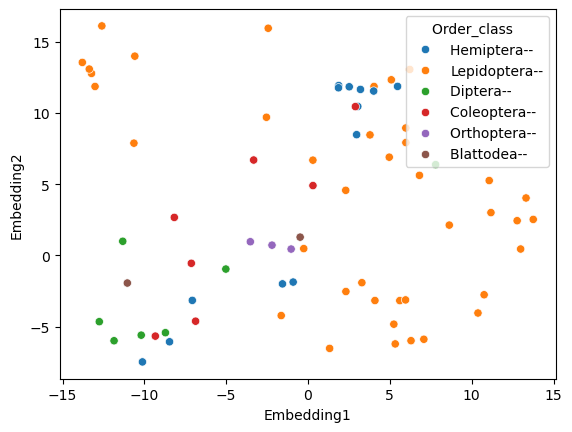

In [17]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

df_path = "output/test_embs.csv"
df = pd.read_csv(df_path, sep=", ")

# plt.scatter(df["Embedding1"], df["Embedding2"], c=df["Order_class  "].to_list())
sns.scatterplot(
    data = df,
    x = "Embedding1",
    y = "Embedding2",
    hue = "Order_class  "
)

Predicted                      , Confidence, Unknown, Level  , Embedding1, Embedding2, Species_class                  , Species_score, Genus_class                    , Genus_score, Family_class  , Family_score, Order_class  , Order_score, Class_class, Class_score
Scarabaeidae--                 , 0.198     , 0.000  , Family , -14.469   , -13.321   , Cissites-maculata-Swederus_1787, 0.039        , Cyclocephala--Dejean_1821      , 0.082      , Scarabaeidae--, 0.198       , Coleoptera-- , 0.742      , Insecta--  , 0.973      
Adhemarius-gannascus-Stoll_1790, 0.439     , 0.000  , Species, 17.828    , -9.479    , Adhemarius-gannascus-Stoll_1790, 0.439        , Adhemarius--Oiticica_Filho_1939, 0.871      , Sphingidae--  , 0.941       , Lepidoptera--, 0.965      , Insecta--  , 0.992      
Acrididae--                    , 0.334     , 0.000  , Family , -1.944    , 14.282    , Aleuas-lineatus-Stl_1878       , 0.046        , Stenopola--Stl_1873            , 0.086      , Acrididae--   , 0.334      

<Axes: xlabel='Embedding1', ylabel='Embedding2'>

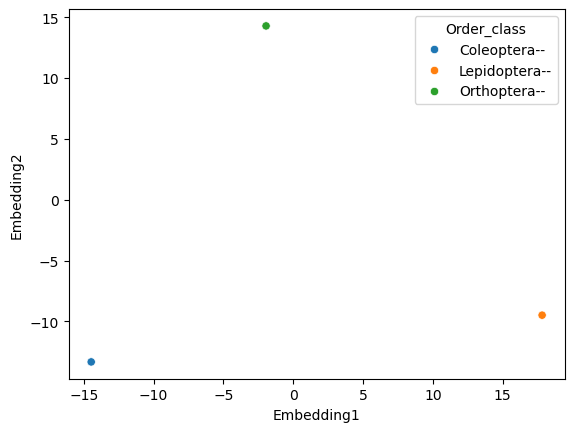

In [1]:
import pandas as pd
import seaborn as sns
from classify import main as classify_main

test_output = classify_main(
    {
        "input" : ["example_image1.jpg", "example_image2.png", "example_image3.png"],
        "output_type" : "short",
        "include_embeddings" : True
    }
)

df = pd.DataFrame(test_output["short"])
# plt.scatter(df["Embedding1"], df["Embedding2"], c=df["Order_class  "].to_list())
sns.scatterplot(
    data = df,
    x = "Embedding1",
    y = "Embedding2",
    hue = "Order_class"
)